In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil

%matplotlib inline
plt.rcParams.update({'font.size': 20})

root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'

In [2]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.model_selection import KFold
from mpl_toolkits.axes_grid1 import ImageGrid
import json

In [3]:
def print_mem():
    memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
    print('Current memory usage: {:.2f}GB'.format(memory_usage))
print_mem()

Current memory usage: 0.62GB


In [4]:
def get_r2(true, prediction):
    u = np.sum((prediction-true)**2)
    v = np.sum((true-np.mean(true))**2)
    return 1 - u / v

In [5]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

In [6]:
directory = os.path.join(root_directory,'fly_5','func_0')
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
clustering_dir = os.path.join(directory, 'super_voxels')
brain = bbb.load_numpy_brain(brain_path)*1 # this *1 is currently important for some fucking reason
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))
print_mem()


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 71.97 ms
brain shape is x,y,z,t (77, 128, 49, 4731)
Current memory usage: 9.77GB


In [7]:
t0 = time.time()
one_slice = brain[:,:,20,:].reshape(-1, brain.shape[-1])
print(time.time()-t0)

0.6487579345703125


In [8]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac_raw = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 57.07 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.96 sec


In [9]:
resolution = 100 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = bbb.smooth_and_interp_fictrac(fictrac_raw,
                                                   fps,
                                                   resolution,
                                                   expt_len,
                                                   behavior,
                                                   timestamps=timestamps,
                                                   smoothing=51)
    fictrac[short] = fictrac[short]/np.std(fictrac[short])
xnew = np.arange(0,expt_len,resolution)

In [10]:
for behavior in ['Y', 'Z']:
    fictrac_std = np.std(fictrac[behavior])
    fictrac[behavior] = np.divide(fictrac[behavior],fictrac_std)

In [27]:
connectivity = grid_to_graph(77,128)

In [12]:
Y_glm = fictrac['Y']

In [28]:
connectivity.shape

(9856, 9856)

In [29]:
n_clusters = [9856,9000,8000,7000,6000,5000,4000,3000,2000,1500,1000,750,500,100,10,1]

cluster_signals = {}

for cluster in n_clusters:
    print('working on cluster {}'.format(cluster))
    model = AgglomerativeClustering(n_clusters=cluster,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    model = model.fit(one_slice)

    signals = []
    for cluster_num in range(cluster):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        mean_signal = np.mean(one_slice[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    X_glm=np.asarray(signals).T
    
    cluster_signals[cluster] = X_glm

working on cluster 9856
working on cluster 9000
working on cluster 8000
working on cluster 7000
working on cluster 6000
working on cluster 5000
working on cluster 4000
working on cluster 3000
working on cluster 2000
working on cluster 1500
working on cluster 1000
working on cluster 750
working on cluster 500
working on cluster 100
working on cluster 10
working on cluster 1


In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [31]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
n_clusters = [9856,9000,8000,7000,6000,5000,4000,3000,2000,1500,1000,750,500,100,10,1]

scores = {}

t00 = time.time()
for cluster in n_clusters:
    print(cluster)
    t0=time.time()
    
    X_glm = cluster_signals[cluster]
    scores[cluster] = {}
    
    for alpha in alphas:
        print(alpha)

        scores[cluster][alpha] = {}
        train_scores = []
        test_scores = []
        
        for train_index, test_index in kf.split(X_glm):

            X_train, X_test = X_glm[train_index], X_glm[test_index]
            Y_train, Y_test = Y_glm[train_index], Y_glm[test_index]

            modelglm = Lasso(alpha=alpha)
            modelglm.fit(X_train, Y_train)
            train_scores.append(modelglm.score(X_train, Y_train))
            test_scores.append(modelglm.score(X_test, Y_test))

        scores[cluster][alpha]['train'] = np.mean(train_scores)
        scores[cluster][alpha]['test'] = np.mean(test_scores)
        
    print('duration {:.0f}s'.format(time.time()-t0))
print('total duration: {:.0f}s'.format(time.time()-t00))

9856
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 204s
9000
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 182s
8000
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 164s
7000
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 144s
6000
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 118s
5000
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 100s
4000
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 84s
3000
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 54s
2000
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duration 30s
1500
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
duratio

In [32]:
timestr = time.strftime("%Y%m%d")
save_path = os.path.join(clustering_dir, 'models', '{}_{}.json'.format(timestr, 'lasso_wardcc'))

with open(save_path, 'w') as fname:
    json.dump(scores, fname)

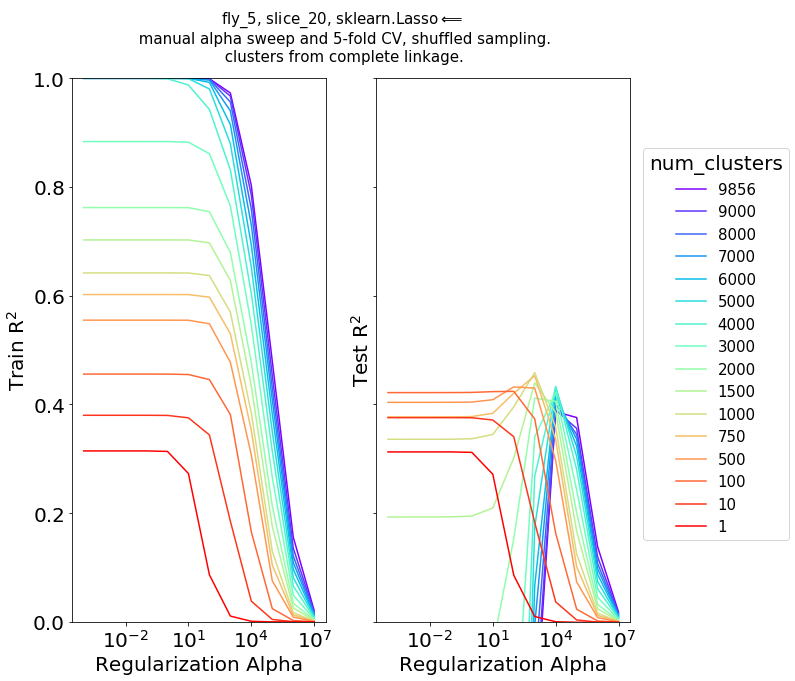

In [18]:
fig, axs = plt.subplots(1,2, figsize=(10,10), sharey=True)

colors = plt.cm.rainbow(np.linspace(0,1,len(n_clusters)))
for i,cluster in enumerate(n_clusters):
    axs[0].plot([x for x in alphas], [scores[cluster][x]['train'] for x in alphas],'-',label=cluster,color=colors[i])
    
for i,cluster in enumerate(n_clusters):
    axs[1].plot([x for x in alphas], [scores[cluster][x]['test'] for x in alphas],'-',label=cluster,color=colors[i])

axs[0].set_ylabel('Train R$^2$')
axs[1].set_ylabel('Test R$^2$')

for ax in axs:
    ax.set_xscale('log')
    ax.set_ylim(0,1)
    ax.set_xlabel('Regularization Alpha')
    
axs[1].legend(loc=(1.05,.15), title='num_clusters',fontsize=15)
plt.suptitle(x=.5,y=.98,t='fly_5, slice_20, sklearn.Lasso$\Longleftarrow$\n manual alpha sweep and 5-fold CV, shuffled sampling.\n clusters from complete linkage.',fontsize=15)


save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [33]:
best_r2s = []
best_alpha = []

for cluster in n_clusters:
    r2s = [scores[cluster][x]['test'] for x in alphas]
    best_r2s.append(np.max(r2s))
    best_alpha.append(alphas[np.argmax(r2s)])

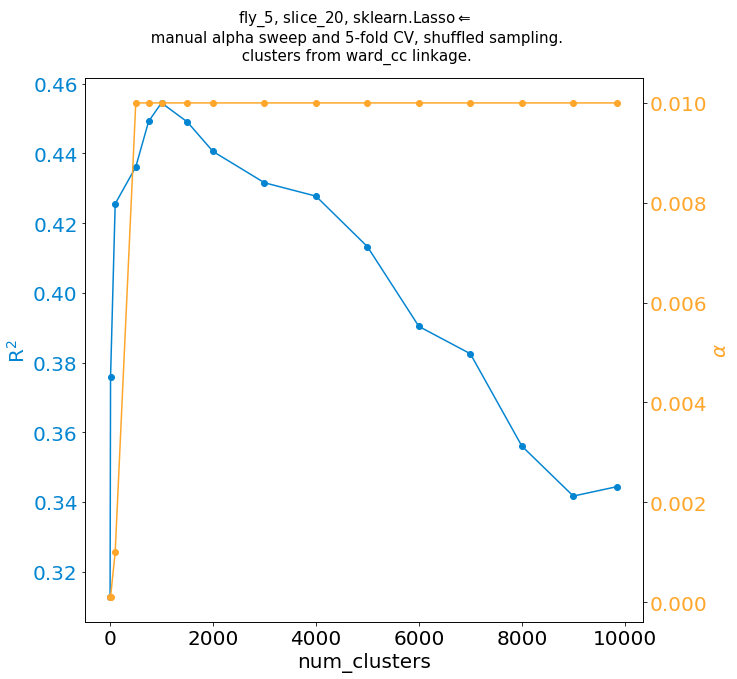

In [35]:
fig, ax1 = plt.subplots(figsize=(10,10))

color = 'xkcd:cerulean'
ax1.set_xlabel('num_clusters')
ax1.set_ylabel('R$^2$', color=color)
ax1.plot(n_clusters, best_r2s, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'xkcd:mango'
ax2.set_ylabel('$\\alpha$', color=color)  # we already handled the x-label with ax1
ax2.plot(n_clusters, best_alpha, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.suptitle(x=.5,y=.98,t='fly_5, slice_20, sklearn.Lasso$\Leftarrow$\n manual alpha sweep and 5-fold CV, shuffled sampling.\n clusters from ward_cc linkage.',fontsize=15)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [142]:
n_clusters = [9856,9000,8000,7000,6000,5000,4000,3000,2000,1500,1000,750,500,100,10,1]

In [58]:
maps = {}
scores = {}

for cluster, alpha in zip(n_clusters, best_alpha):
    print(cluster)
    t0=time.time()
    
    ### CLUSTER ###
    model = AgglomerativeClustering(n_clusters=cluster,
                                memory=clustering_dir,
                                linkage='complete',
                                connectivity=None)
    model = model.fit(one_slice)
    
    ### Fit Linear Model ###
    X_glm = cluster_signals[cluster]
    scores[cluster] = {}
    
    train_scores, test_scores, coefs = [], [], []

    for train_index, test_index in kf.split(X_glm):

        X_train, X_test = X_glm[train_index], X_glm[test_index]
        Y_train, Y_test = Y_glm[train_index], Y_glm[test_index]

        modelglm = Lasso(alpha=alpha)
        modelglm.fit(X_train, Y_train)
        train_scores.append(modelglm.score(X_train, Y_train))
        test_scores.append(modelglm.score(X_test, Y_test))
        coefs.append(modelglm.coef_)

    scores[cluster]['train'] = np.mean(train_scores)
    scores[cluster]['test'] = np.mean(test_scores)
    scores[cluster]['coef'] = np.mean(coefs,axis=0)
    
    ### Color brain by coefs ###
    colored_by_betas = np.zeros(77*128)
    for cluster_num in range(cluster):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        colored_by_betas[cluster_indicies] = scores[cluster]['coef'][cluster_num]
    colored_by_betas = colored_by_betas.reshape(77,128)
    
    maps[cluster] = colored_by_betas
        
    print('duration {:.0f}s'.format(time.time()-t0))

9856
duration 15s
9000
duration 13s
8000
duration 11s
7000
duration 10s
6000
duration 9s
5000
duration 6s
4000
duration 5s
3000
duration 4s
2000
duration 2s
1500
duration 2s
1000
duration 1s
750
duration 1s
500
duration 1s
100
duration 0s
10
duration 0s
1
duration 0s


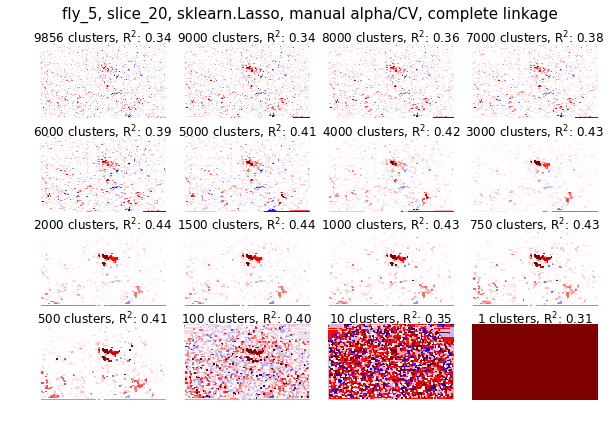

In [59]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.25)
#n_clusters = [9856, 1000]
for i,cluster in enumerate(n_clusters):
    grid[i].imshow(maps[cluster], cmap='seismic', vmin=-np.max(maps[cluster]), vmax=np.max(maps[cluster]))
    grid[i].axis('off')
    grid[i].set_title('{} clusters, R$^2$: {:.2f}'.format(cluster, scores[cluster]['test']),
                      fontsize=12,
                      x=.5,y=1.1,
                      horizontalalignment='center',
                      verticalalignment='top')
plt.suptitle(x=.5,y=.8,t='fly_5, slice_20, sklearn.Lasso, manual alpha/CV, complete linkage',fontsize=15)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')